In [1]:
# Define parameters to run
tickers = ['TSLA']
start = "2022-03-01"
end   = "2022-03-02"


In [2]:
import os 
import pandas as pd
import json
import requests
import numpy as np
import math
from pathlib import Path
import csv # using Python module
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import TimeFrame
import matplotlib.pyplot as plt
%matplotlib inline




Bad key text.latex.preview in file /Users/dallolmac/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /Users/dallolmac/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.0/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /Users/dallolmac/opt/anaconda3/envs/pyvizenv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig

In [3]:

import alpaca_trade_api as tradeapi

alpaca_api_key='PKJBN0LO4GAQX16TZSHA'
alpaca_secret='tNcYpRpFM3ITeyun6OTpdukBbTaN33q6IIi6bdHF'

api = tradeapi.REST(alpaca_api_key, alpaca_secret, api_version = 'v2')


In [4]:
def getprice(ticker, start, end):
  # Set start and end datetimes 
  start_date = pd.Timestamp(start, tz="America/New_York").isoformat()
  end_date = pd.Timestamp(end, tz="America/New_York").isoformat()

  # Make api call to get ticker information
  #df_m = api.get_bars(ticker, '1Min', limit = None, start = start_date, end = end_date).df
  df_m = api.get_bars(ticker, TimeFrame.Minute, limit = None, start = start_date, end = end_date).df
  # Drop extra level in the alpaca api result
  #df_m = df_m.droplevel(level=0,axis=1) ##MD

  # Make API call for daily data
  #df_d = api.get_bars(ticker, '1D', limit = None, start = start_date, end = end_date).df
  df_d = api.get_bars(ticker, TimeFrame.Day, limit = None, start = start_date, end = end_date).df
  #df_d = df_d.droplevel(level=0,axis=1) ##MD

  return df_m, df_d


In [5]:
def prepareDF(df):
  # Add a day_part column
  df_m['day_part'] = None


  # Add Day number of week 
  # 0 - Monday   |  6 - Sunday
  #days_of_week = pd.get_dummies(df_m.index.dayofweek, prefix='weekday', drop_first=True)
  df_m['day_of_week'] = df_m.index.dayofweek


  # Get day segments based on time
  seg1 = df.between_time('06:00', '09:30')
  seg2 = df.between_time('09:30', '11:00')
  seg3 = df.between_time('11:00', '15:00')
  seg4 = df.between_time('15:00', '16:00')
  seg5 = df.between_time('16:00', '20:00')

  # Add day_part information
  df.loc[seg1.index, 'day_part'] = 'pre_market'
  df.loc[seg2.index, 'day_part'] = 'morning_pop'
  df.loc[seg3.index, 'day_part'] = 'laze_fair'
  df.loc[seg4.index, 'day_part'] = 'power_hour'
  df.loc[seg5.index, 'day_part'] = 'happy_hour'  

  # Cumulative Volume up to this record * include pre market
  df['cum_vol_all_hours']=None

  # Cumulative Vol up to this record for this day part
  df['cum_vol_for_day_part']=None

  # rvol (current time vol)
  # 1D means (so far)/yesterday
  
  df['rvol_1D']=None
  df['rvol_3D']=None
  df['rvol_5D']=None
  df['rvol_14D']=None
  df['rvol_21D']=None  

  # Add 20 min pct change return
  df['return_15m'] = df['close'].pct_change(15)


  return df

In [6]:
# Define LSTM 21 deep array for keeping previous data
def init_lstm():
  num_days_trace = 21
  def_vals = np.zeros(shape=(num_days_trace,1))
  lstm = pd.DataFrame(data=def_vals, columns=['one_day'])
  for col in lstm.columns:
      lstm[col] = None
  return lstm

#lstm = pd.DataFrame(pd.Series[No])

In [7]:
def getCumVols(df):
  # Calculate the volume cumulative sum for all day and per day part
  # Convert Volume to numeric MD
  pd.to_numeric(df_m['volume'])
  df_m['volume'].astype(int)
  df_m['cum_vol_all_hours'] = df_m.groupby(by=df_m.index.date).volume.cumsum()
  # Cumulative Vol up to this record for this day part
  df_m['cum_vol_for_day_part']=df_m.groupby(by=[df_m.index.date, 'day_part']).volume.cumsum()

  return df

#df_m['volume'].dtype

In [8]:

def getVolFromDayData(one_day, time_stamp):
  # Get the last vol (in case we have a minute missing)
  matched = one_day[one_day.index < time_stamp]
  print('======================================= ')
  print(matched)
  print('*************************************** ')
  if matched is not None and matched.size>0:
    matched_vol = matched.tail(1).cum_vol_all_hours
    print('--> ', matched_vol[0], type(matched_vol), ' --- len ', len(matched_vol))
    return matched_vol[0]
  else:
    return 0

## -----------------------------------------------------------------------------

def getVolTillTime(lstm, time_stamp, period):
  vol=0 
  days=0
  for i in range(len(lstm)):
    if lstm.iloc[i,0] is not None and lstm.iloc[i,0].index[0].date() < time_stamp.date():
      vol += getVolFromDayData(lstm.iloc[i,0], time_stamp)
      days += 1
      if i==period:
        break
  print('*************************************** ', type(vol), ' -------' , vol)        
  if vol == 0:
    vol = 0 
  else:
    vol = vol/days
  print('*************************************** ', type(vol), ' -------' , vol)
  return vol


In [9]:
# Get minute and daily stock data
df_m, df_d = getprice('TSLA', start, end)

In [10]:
df_d.head()

,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,
2022-03-01 05:00:00+00:00,869.97,889.88,853.7800,864.37,24157613,648573,867.666133
2022-03-02 05:00:00+00:00,872.13,886.48,844.2721,879.89,24402912,672823,865.953218


In [11]:
for ticker in tickers:
  print(ticker)
  # Get minute and daily stock data
  df_m, df_d = getprice(ticker, start, end)

  # Prepare data frame with columns needed
  df_m = prepareDF(df_m)

  # Get cumulative vols to be used later
  df_m = getCumVols(df_m)

  #def get_rvol(df, period):
  lstm = init_lstm()

  # get all unique dates in the dataset
  dates = df_m.groupby(by=df_m.index.date)
  first_day = True
  # Loop through each date
  c=0
  for one_day_index, one_day in dates:
    print('---> Porcessing RVOL for ', one_day.index[0].date())


    # Save current day in the lstm
    lstm = lstm.shift(1)
    # Save the whole one day dataframe
    lstm.iat[0, 0] = one_day
    
    # If first day then do nothing
    if first_day:
      first_day = False
      continue;

    record_count=0
    # Loop thorugh each minute or row within the date provided
    for one_min_index, one_min in one_day.iterrows():
      
      # calculat rvol for pervious periods
      cvol=0

      # 1D RVOL (today/yesterday) up till the curren ttime for both days
      cvol = getVolTillTime(lstm, one_min.name, 1)
      df_m.loc[one_min.name, 'rvol_1D'] = one_min['cum_vol_all_hours']/cvol

      # 3D RVOL (today/average of last 3 days) up till the curren ttime for both days
      cvol = getVolTillTime(lstm, one_min.name, 3)
      df_m.loc[one_min.name, 'rvol_3D'] = one_min['cum_vol_all_hours']/cvol

      # 5D RVOL (today/average of last n days) up till the curren ttime for both days
      cvol = getVolTillTime(lstm, one_min.name, 5)
      df_m.loc[one_min.name, 'rvol_5D'] = one_min['cum_vol_all_hours']/cvol

      # 14D RVOL (today/average of last n days) up till the curren ttime for both days
      cvol = getVolTillTime(lstm, one_min.name, 14)
      df_m.loc[one_min.name, 'rvol_14D'] = one_min['cum_vol_all_hours']/cvol

      # 14D RVOL (today/average of last n days) up till the curren ttime for both days
      cvol = getVolTillTime(lstm, one_min.name, 21)
      df_m.loc[one_min.name, 'rvol_21D'] = one_min['cum_vol_all_hours']/cvol

    # Save off the file so we don't have to process again
    # Write the DataFrame to CSV file.
    file_path = (f'./Resources/{ticker}.csv')
    df_m.to_csv(file_path)



TSLA
---> Porcessing RVOL for  2022-03-01
---> Porcessing RVOL for  2022-03-02
                               open    high       low   close  volume  \
timestamp                                                               
2022-03-01 09:00:00+00:00  868.0000  872.00  868.0000  868.79    4272   
2022-03-01 09:01:00+00:00  868.3000  869.05  868.0000  869.00    2348   
2022-03-01 09:02:00+00:00  868.1100  869.30  868.0000  869.30    1953   
2022-03-01 09:03:00+00:00  868.0000  868.11  868.0000  868.11    1552   
2022-03-01 09:05:00+00:00  866.6500  866.65  866.6500  866.65    1030   
...                             ...     ...       ...     ...     ...   
2022-03-01 23:49:00+00:00  863.0000  863.00  863.0000  863.00     606   
2022-03-01 23:51:00+00:00  863.9499  863.95  863.9499  863.95     494   
2022-03-01 23:56:00+00:00  863.9400  863.94  863.9400  863.94     572   
2022-03-01 23:58:00+00:00  863.9500  864.30  863.9500  864.30    5550   
2022-03-01 23:59:00+00:00  864.3000  864.30  

In [12]:
df_m

,open,high,low,close,volume,trade_count,vwap,day_part,day_of_week,cum_vol_all_hours,cum_vol_for_day_part,rvol_1D,rvol_3D,rvol_5D,rvol_14D,rvol_21D,return_15m
timestamp,,,,,,,,,,,,,,,,,
2022-03-01 09:00:00+00:00,868.00,872.00,868.0000,868.79,4272,259,869.799511,pre_market,1,4272,4272,None,None,None,None,None,NaN
2022-03-01 09:01:00+00:00,868.30,869.05,868.0000,869.00,2348,137,868.551231,pre_market,1,6620,6620,None,None,None,None,None,NaN
2022-03-01 09:02:00+00:00,868.11,869.30,868.0000,869.30,1953,146,868.578740,pre_market,1,8573,8573,None,None,None,None,None,NaN
2022-03-01 09:03:00+00:00,868.00,868.11,868.0000,868.11,1552,98,868.162945,pre_market,1,10125,10125,None,None,None,None,None,NaN
2022-03-01 09:05:00+00:00,866.65,866.65,866.6500,866.65,1030,76,866.847000,pre_market,1,11155,11155,None,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-02 00:54:00+00:00,864.80,864.80,864.8000,864.80,590,21,864.729356,None,2,43929,-1,0.001832,0.001832,0.001832,0.001832,0.001832,0.000926
2022-03-02 00:55:00+00:00,864.60,864.60,864.6000,864.60,422,35,864.736137,None,2,44351,-1,0.00185,0.00185,0.00185,0.00185,0.00185,0.000926
2022-03-02 00:57:00+00:00,864.40,864.50,864.4000,864.50,952,50,864.474212,None,2,45303,-1,0.00189,0.00189,0.00189,0.00189,0.00189,0.000579


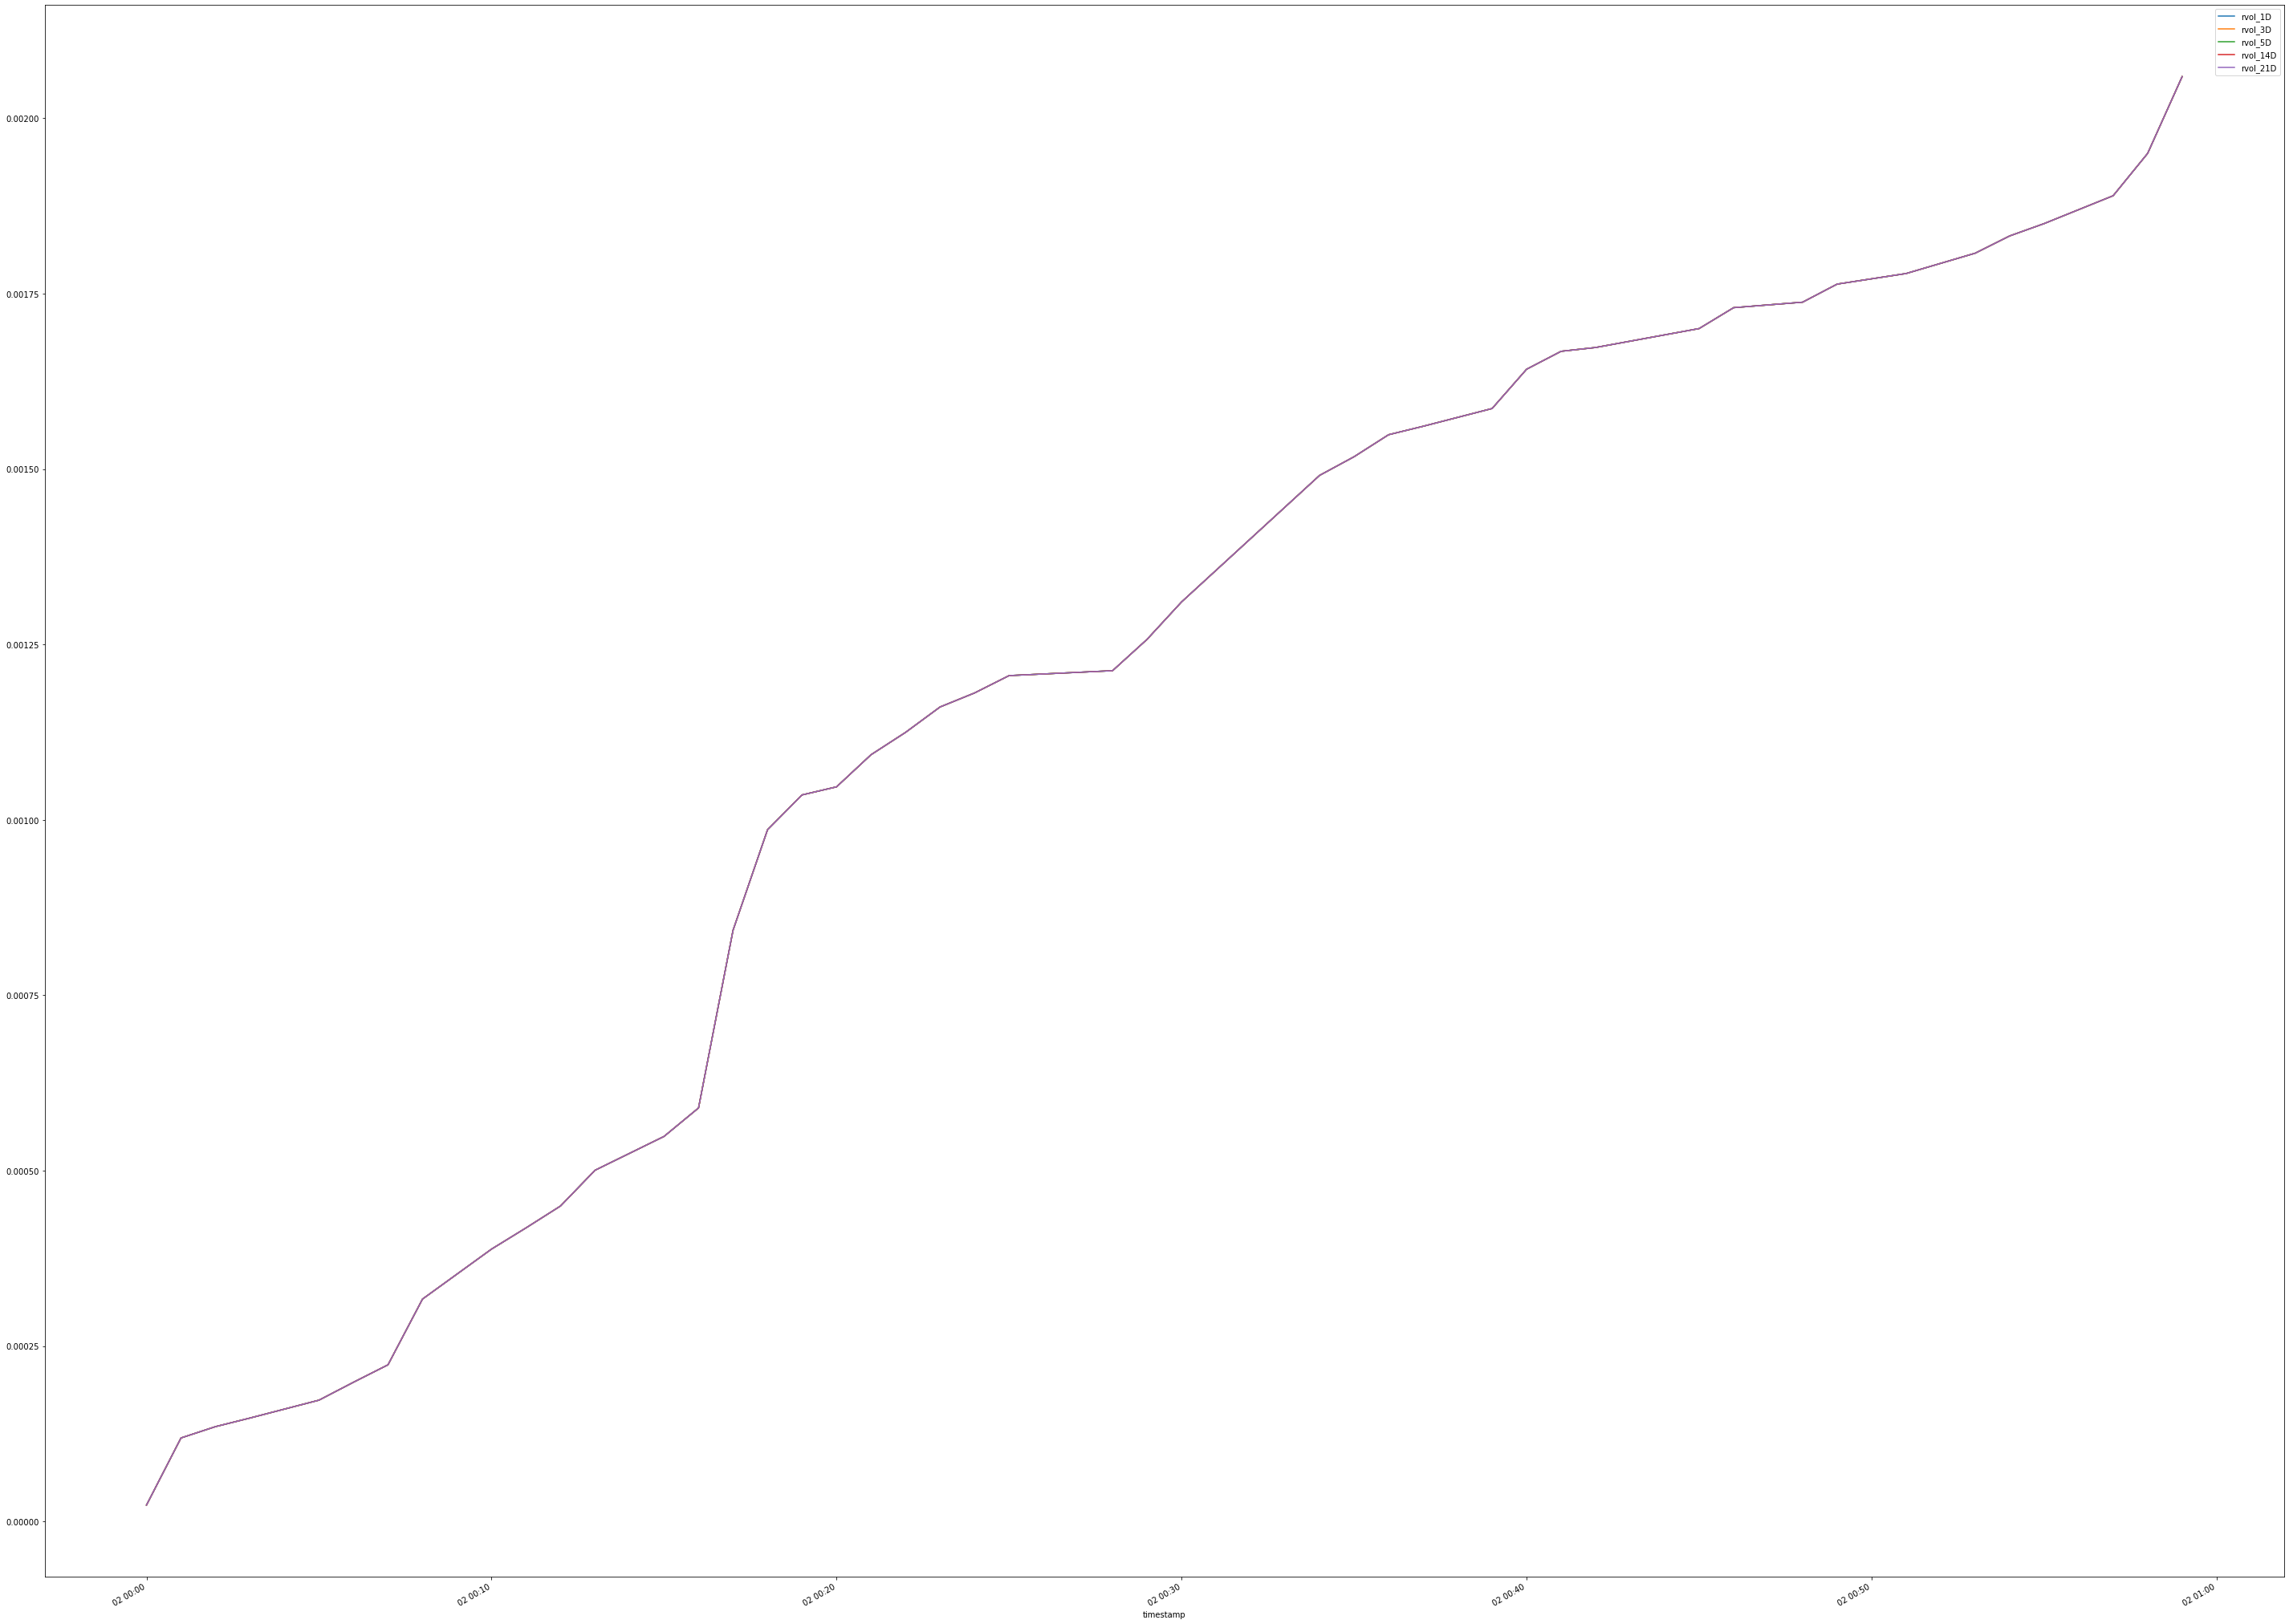

In [16]:
# Plot Data
df_m.rvol_1D.plot(figsize=(50,40))
df_m.rvol_3D.plot()
df_m.rvol_5D.plot()
df_m.rvol_14D.plot()
df_m.rvol_21D.plot()
plt.legend()